The goal of this notebook is to distill down the essential compenents of training HF models in a way that is easy to port to a data pipeline and apply to new model training scenarios.

# Imports

In [1]:
import numpy as np
import wandb
import transformers
import IPython
import peft
print(np.__version__)
print(wandb.__version__)
print(transformers.__version__)
print(IPython.__version__)
print(peft.__version__)

1.26.1
0.16.0
4.34.1
8.16.1
0.5.0


In [2]:
#from huggingface_hub import login
import os
import pandas as pd
from rich import print
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

pd.set_option('display.max_colwidth', None)

# Define variables

In [3]:
seed = 42 #reproducability  over training runs
clobber_project_dir = False #wipe the project director clean
project_dir = "chat_summarizer" #project name, also used as wandb project name

#creds
hf_token = os.environ["HF_TOKEN"]
wandb_key = os.environ["WANDB_KEY"]
hf_account_name = os.environ["HF_ACCOUNT_NAME"]

#HF touchpoints
hf_dataset_name = "knkarthick/dialogsum"
source_hf_model_name = "meta-llama/Llama-2-7b-hf"
destination_hf_model_name = f"{hf_account_name}/llama2-7b-dialogsum-qlora-gptq"
checkpoint_dir = "best_checkpoint"
quantization_dir = 'quantized_8bit'
merged_dir = 'merged_model'
quantized_train_dir = 'quant_trained_model_new'
project_path = os.path.join(project_dir, checkpoint_dir)
quant_path = os.path.join(project_dir, quantization_dir)
quantized_train_path = os.path.join(project_dir, quantized_train_dir)

train_test_split_ratio = 0.1

#LoRA hparams
lora_r = 64  # rank
lora_alpha = lora_r * 2
lora_dropout = 0.05

#training hparams
epochs = 2
per_device_train_batch_size=8
gradient_accumulation_steps=4
early_stopping_patience = 3
learning_rate = 3e-4
logging_steps = 25
device = "cuda"
max_training_sample_length = 2048

#quantization params
quantization_bits = 8

## State of working directory

In [4]:
print(project_dir)
!mkdir -p $project_dir

#Set clobber_project_dir to True to reset working directory
if clobber_project_dir:
    !rm -rf ./$project_dir

!ls -latrs ./$project_dir

chat_summarizer

total 0
0 drwxr-xr-x 1 root root 4096 Nov  5 04:48 runs
0 drwxr-xr-x 1 root root 4096 Nov  5 10:18 checkpoint-500
0 drwxr-xr-x 1 root root 4096 Nov  5 12:28 best_checkpoint
0 drwxr-xr-x 1 root root 4096 Nov  5 17:35 quantized
0 drwxr-xr-x 1 root root 4096 Nov  6 08:53 quantized_8bit
0 drwxr-xr-x 1 root root 4096 Nov  6 21:07 quant_trained_model
0 drwxr-xr-x 1 root root 4096 Nov  8 18:09 quant_trained_model1
0 drwxr-xr-x 1 root root 4096 Nov  9 04:01 .
0 drwxr-xr-x 1 root root 4096 Nov  9 04:07 quant_trained_model_new
0 drwxr-xr-x 1 root root 4096 Nov  9 05:01 ..


## Initiate wandb

In [5]:
import wandb

wandb.login(key = wandb_key)
run = wandb.init(project=project_dir, job_type="training", anonymous="allow")

wandb: Currently logged in as: jason-anderson-professional. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Process data for training

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator


def analyze_generation_params(text):
    print(text,"-"*60)
    results = []
    for temp in np.linspace(.5,1.5,num = 5):
        print(f"temp {temp}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=185,temp=temp))
    
    print("-"*60)
    results = []
    for top_p in np.linspace(0,1,num = 11):
        print(f"top_p {top_p}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=185,temp=.7, top_p=top_p))
    
    
    print("-"*60)
    results = []
    for top_k in np.linspace(0,100,num = 11,dtype=int):
        print(f"top_k {top_k}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=185, top_k=int(top_k)))
    
    print("-"*60)
    results = []
    for do_sample in [True,False]:
        print(f"do_sample {do_sample}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=185, do_sample = do_sample, top_k=None))
    
    
    print("-"*60)
    results = []
    for repetition_penalty in np.linspace(1.,2.,num=11):
        print(f"repetition_penalty {repetition_penalty}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=48,repetition_penalty=repetition_penalty))
    
    print("-"*60)
    results = []
    for typical_p in np.linspace(.1,.9,num=9):
        print(f"typical_p {typical_p}:",end="")
        results.append(generate(text, persisted_model, prompt=False, max_new_tokens=48,typical_p=typical_p))


def generate(text, model, prompt=False, temp=0.7,top_k= 40, top_p = 0.1, do_sample = True, repetition_penalty = 1.23, typical_p = 1, guidance_scale = 1, max_new_tokens = 24,):
    from transformers import TextStreamer
    if prompt:
        print(text,"-"*20)
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=False)
    inputs = tokenizer(text, return_tensors="pt").to('cuda')

    # Call the generate method of the model with the given inputs and additional generation configurations.
    outputs = model.generate(**inputs,  # "inputs" likely includes input_ids or prompts for generation.
                           streamer=streamer,  # "streamer" not a standard parameter in HF documentation, likely custom for model-specific streaming.
                           max_new_tokens=max_new_tokens,  # Sets the maximum number of new tokens to generate; range varies based on model and computational limits.
                           temperature=temp,  # Controls randomness: lower->more deterministic, higher->more random; typically in range [0.5, 1.5].
                           do_sample=do_sample,  # Enables sampling; when True, picks tokens based on probability distribution, rather than just most likely.
                           top_p=top_p,  # Nucleus sampling: selects top p% probability tokens for sampling; range [0, 1].
                           top_k=top_k,  # Top-k sampling: chooses from top k probability tokens; if k=0, it's the same as using no top-k.
                           repetition_penalty=repetition_penalty,  # Penalizes repeated tokens; >1 discourages, <1 encourages repetition; typically close to 1.
                           typical_p=typical_p,  # Typical sampling; selects tokens whose cumulative probability is above this threshold, range [0, 1], usually close to 1.
                           guidance_scale=guidance_scale,  # Affects the scale of guidance in models that support it, like CTRL; standard range not well-defined.
                           #seed=seed,  # Sets a seed for reproducibility; commented out, so not in use.
                          )
    generated_tokens = outputs[0].tolist()[len(inputs[0]):]
    result = tokenizer.decode(generated_tokens)
    return result

def set_plot_appearance(fontsize_title=14, 
                        fontsize_label=12, 
                        fontsize_ticks=8, 
                        theme='dark'):
    """
    Configure the plot's appearance with font sizes and theme for dark backgrounds.
    
    Parameters:
    fontsize_title: Font size for the title.
    fontsize_label: Font size for the x and y labels.
    fontsize_ticks: Font size for the x and y tick labels.
    theme: Seaborn theme for the plot's aesthetic style.
    """
    sns.set_theme(style=theme, palette='pastel')
    
    plt.rcParams.update({
        'figure.facecolor': '#1a1a1a',  # Very dark grey background for the figure
        'axes.facecolor': '#1a1a1a',    # Very dark grey background for the plots
        'grid.color': 'gray',           # Lighter grey grid lines (less contrast)
        'text.color': 'white',          # White text for better contrast on dark bg
        'axes.labelcolor': 'white',     # White labels for axes
        'xtick.color': 'white',         # White x-tick labels
        'ytick.color': 'white',         # White y-tick labels
        'axes.labelsize': fontsize_label,
        'axes.titlesize': fontsize_title,
        'xtick.labelsize': fontsize_ticks,
        'ytick.labelsize': fontsize_ticks,
        'legend.title_fontsize': fontsize_ticks + 2,
        'legend.fontsize': fontsize_ticks,
        'axes.edgecolor': 'lightgrey',  # Light grey color for the axes' spines
    })
# Possible modern themes: 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'.
# Example usage: set_plot_appearance(theme='ticks')

def plot_text_length_histogram(df, bucket_size=64, percentile=95):
    """
    Plot a histogram of text lengths and indicate the percentile.

    Parameters:
    df: the pandas dataframe to render from
    bucket_size: the number of characters to bucket the histogram with
    percentile: draws a vertical line at this percentile to visualize whether an acceptable fraction of the data lenghts are being used for training set
    """
    set_plot_appearance()  # Apply appearance settings to the plot
    text_lengths = df['text'].apply(len)  # Calculate text lengths.
    bins = range(0, max(text_lengths) + bucket_size, bucket_size)  # Define histogram bins.
    percentile_value = np.percentile(text_lengths, percentile)  # Calculate percentile value.

    fig, ax = plt.subplots()  # Create figure and axis objects.
    ax.hist(text_lengths, bins=bins, edgecolor='black', alpha=0.7)  # Plot histogram.
    ax.axvline(x=percentile_value, color='red', linestyle='--')  # Draw percentile line.
    
    # Annotate the percentile line.
    ax.text(percentile_value, ax.get_ylim()[1]*0.9, f' {percentile}th Percentile: {int(round(percentile_value, -1))}',
            color='red', ha='left')

    ax.set_xlabel('Text Length')  # Set x-axis label.
    ax.set_ylabel('Frequency')  # Set y-axis label.
    ax.set_title('Histogram of Text Lengths')  # Set title.

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set major locator for x-axis.
    plt.show()  # Display the plot.

def visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True):
    """
    Visualize the frequency of top categories in training and test datasets.
    """
    set_plot_appearance()  # Apply appearance settings to the plot

    # Get top x categories from both datasets.
    train_topic_norm = train_df['topic'].value_counts(normalize=normalize).head(top_x)
    test_topic_norm = test_df['topic'].value_counts(normalize=normalize).head(top_x)
    
    # Prepare the data for plotting.
    train_topics = pd.DataFrame({'topic': train_topic_norm.index, 'frequency': train_topic_norm.values, 'dataset': 'Training'})
    test_topics = pd.DataFrame({'topic': test_topic_norm.index, 'frequency': test_topic_norm.values, 'dataset': 'Test'})
    combined_topics = pd.concat([train_topics, test_topics])

    sns.barplot(x='frequency', y='topic', hue='dataset', data=combined_topics)  # Create bar plot.
    plt.title('Top {} Topics Frequency Comparison'.format(top_x))  # Set title.
    plt.xlabel('Normalized Frequency')  # Set x-axis label.
    plt.ylabel('Topic')  # Set y-axis label.
    plt.tight_layout()  # Adjust layout.
    plt.show()  # Display the plot.



def get_data_stuff(dataset_name, split_ratio=0.2):    
    # %%
    from datasets import load_dataset
    from datasets import Dataset
    import pandas as pd
    pd.set_option('display.max_colwidth', None)
    
    
    #load the dataset
    dataset = load_dataset(dataset_name)
    
    # Shuffle the dataset (setting seed for reproducibility)
    shuffled_ds = dataset['train']#.shuffle(seed=seed)
    #shuffled_ds = shuffled_ds.select(range(1000))

    
    # Split the dataset into training and test sets with a test size of 20%
    train_test_split = shuffled_ds.train_test_split(test_size=train_test_split_ratio, seed = seed)
    
    # The train/test datasets are now accessible as follows:
    train_ds = train_test_split['train']
    raw_train_df = pd.DataFrame(train_ds)
    
    test_ds = train_test_split['test']
    raw_test_df = pd.DataFrame(test_ds)
    
    prepared_train_df = prepare_dataset(raw_train_df, "train")
    prepared_test_df = prepare_dataset(raw_test_df, "test")

    prepared_train_dataset = Dataset.from_pandas(prepared_train_df)
    prepared_test_dataset = Dataset.from_pandas(prepared_test_df)
    
    print(f"length of downloaded ds: {len(shuffled_ds)}")
    print(f"length of train_ds: {len(prepared_train_dataset)}")
    print(f"length of test_ds: {len(prepared_test_dataset)}")
    estimated_training_steps = epochs * len(prepared_train_dataset) / per_device_train_batch_size / gradient_accumulation_steps
    print(f"estimated training steps will be {estimated_training_steps}")
    return prepared_train_df, prepared_test_df, prepared_train_dataset, prepared_test_dataset


def prepare_dataset(df, split="train"):
    text_col = []
    instruction = """Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only provide full sentence responses."""  # change instuction according to the task
    if split == "train":
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            output = row["summary"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
                + output
                + "\n### End"
            )  # keeping output column in training dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    else:
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
            )  # not keeping output column in test dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    return df



In [7]:
train_df, test_df, train_dataset, test_dataset = get_data_stuff(hf_dataset_name, 
                                                                split_ratio=train_test_split_ratio,
                                                               )
text = test_df['text'][1]

length of downloaded ds: 12460

length of train_ds: 11214

length of test_ds: 1246

estimated training steps will be 700.875

In [8]:
print(text)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

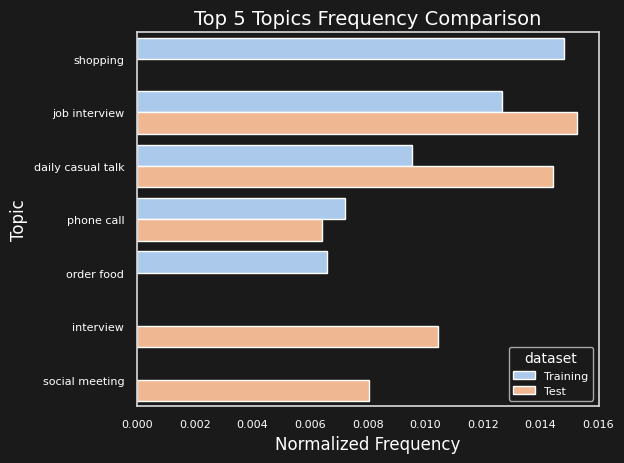

In [9]:
#to enhance training, consider rolling the shuffle dice until you get good consistency between training and test set categories.
visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True)

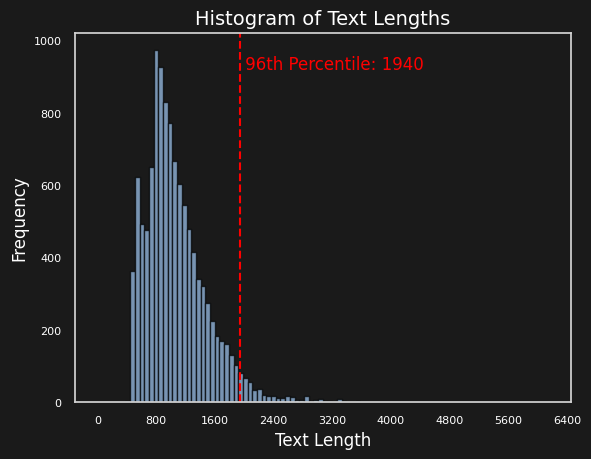

In [10]:
#this just measures space-delimited words which isn't necessarily the same as toke count, but it should be close-ish
plot_text_length_histogram(train_df, percentile = 96)

## Load source model/tokenizer

In [ ]:
%%time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

# loading the model with quantization config
model = AutoModelForCausalLM.from_pretrained(
    source_hf_model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
    token = hf_token,
)

model.config.use_cache = True  #surpress the download and use cache. # apparently needed because of https://github.com/huggingface/transformers/pull/24906
model.config.pretraining_tp = 1  #disable tensor parallelism
#print(model)

#fixme
tokenizer = AutoTokenizer.from_pretrained(
    source_hf_model_name, 
    trust_remote_code=True, 
    return_token_type_ids=False,
    token = hf_token,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
%%time
import trl
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
from trl import SFTTrainer
from transformers import EarlyStoppingCallback
import transformers



# Parameter efficient finetuning for LoRA configuration

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    #target_modules=[ "q_proj","v_proj",],  # we will only create adopters for q, v metrices of attention module
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"],
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)


training_arguments = transformers.TrainingArguments(
    output_dir=project_dir,
    #load_from_checkpoint=str,
    seed = seed,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_8bit",
    learning_rate= learning_rate,
    #lr_scheduler_type="linear",
    save_strategy="steps",
    logging_steps=logging_steps,
    num_train_epochs=epochs,
    max_steps=0,
    fp16=True,
    push_to_hub=False,
    evaluation_strategy="steps",  # Add this line
    eval_steps=logging_steps,  # Add this line
    metric_for_best_model="loss",
    greater_is_better=False,
    load_best_model_at_end=True,
)
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,  # passing peft config
    dataset_text_field="text",  # mentioned the required column
    args=training_arguments,  # training agruments
    tokenizer=tokenizer,  # tokenizer
    packing=False,
    max_seq_length=max_training_sample_length,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
)

## Train lora

In [ ]:
%%time
if False:
    trainer.train()

In [ ]:
print("done!")

## save peft model

In [ ]:
%%time
import os
trainer.model.save_pretrained(project_path)

In [ ]:
project_dir

In [ ]:
!ls -lhatrs ./$project_path/

In [ ]:
!ls -latrsh ./$project_path

In [ ]:
!cat ./$project_path/README.md


## Load peft model from checkpoint on disk

In [ ]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig.from_pretrained(project_path)
lmodel = get_peft_model(model, lora_config)

In [ ]:
#text = test_df['text'][500]
print(text)
result = generate(text, lmodel, max_new_tokens=64, temp=0.1)
#del lmodel

In [ ]:
#del  model

In [ ]:
result

## load the orignal mode

In [ ]:
project_path

In [ ]:
%%time
from peft import AutoPeftModelForCausalLM
from transformers import  AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(
#     source_hf_model_name, 
#     trust_remote_code=True, 
#     return_token_type_ids=False,
#     token = hf_token,
# )
tokenizer = AutoTokenizer.from_pretrained(source_hf_model_name)
persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    project_path,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
    token=hf_token,
)


In [ ]:
#text = test_df['text'][500]
print(text)
result = generate(text, persisted_model, max_new_tokens=64, temp=0.1)
#del persisted_model

In [ ]:
result

In [ ]:
del persisted_model

## Merge the lora and original model

In [ ]:
merged_dir
!ls -lathrs $merged_dir

In [ ]:
%%time


merged_model = persisted_model.merge_and_unload(progressbar=True)

merged_model.save_pretrained(merged_dir, safe_serialization=True)
tokenizer.save_pretrained(merged_dir)

del persisted_model

## Load merged model from disk

In [ ]:
%%time
tokenizer = AutoTokenizer.from_pretrained(merged_dir)
merged_model_from_disk = AutoModelForCausalLM.from_pretrained( merged_dir, device_map=device)

In [ ]:
print(text)
result = generate(text, merged_model_from_disk,max_new_tokens=64, temp = 0.01)

In [ ]:
#del merged_model_from_disk

## Quantize it

In [ ]:
merged_dir

In [ ]:
%%time
from transformers import GPTQConfig

quantization_config = GPTQConfig(
    bits=quantization_bits,
    dataset=["c4"],
    desc_act=False,
)

quant_model = AutoModelForCausalLM.from_pretrained(
    merged_dir, 
    quantization_config=quantization_config, 
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(merged_dir)

In [ ]:
#del persisted_model

## Save quantized model to disk

In [ ]:
quant_path

In [ ]:
%%time

quant_path = os.path.join(project_dir, quantization_dir)
print(f"saving to {quant_path}")

# Save the quantized model
quant_model.save_pretrained(quant_path, safe_serialization=True)
tokenizer.save_pretrained(quant_path)
#del persisted_model

In [ ]:
print(quant_path)
!ls -latrsh $quant_path

## Load quantized model from disk

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

print(quant_path)
quant_model_from_disk = AutoModelForCausalLM.from_pretrained( quant_path, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(quant_path)

In [ ]:
print(text,"\n","="*30)
result = generate(text, quant_model_from_disk,max_new_tokens=64, temp = 0.1)

In [ ]:
result

## Push model to HuggingFace hub

In [ ]:
%%time

tokenizer.push_to_hub(destination_hf_model_name, token=hf_token)
quant_model_from_disk.push_to_hub(destination_hf_model_name, token = hf_token)

In [ ]:
%%time
# %%
#from transformers import GPTQConfig

# quantization_config = GPTQConfig(
#     bits=4,
#     dataset=["c4"],
#     desc_act=False,
# )
#quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)
from_disk_quant_model = AutoModelForCausalLM.from_pretrained(
    destination_hf_model_name, 
    #quantization_config=quantization_config_loading, 
    device_map=device,
)
tokenizer = AutoTokenizer.from_pretrained(destination_hf_model_name)

## Test the model by pulling from hugging face hub

In [ ]:
#text = test_df['text'][500]
text = test_df['text'][4]
print(text)
result = generate(text, from_disk_quant_model, max_new_tokens=85,temp=1)

In [ ]:
result

# Train a GPTQ model

In [11]:
from huggingface_hub import login
from dotenv import load_dotenv

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
from transformers import GPTQConfig
from transformers import Trainer, TrainingArguments #, DataCollatorForLanguageModeling
from trl import SFTTrainer

model_id = "TheBloke/Llama-2-7B-GPTQ"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


quantization_config_loading = GPTQConfig(bits=4, 
                                         disable_exllama=True,
                                        )
lora_config = LoraConfig(
                            r=8,
                            lora_alpha=32,
                            target_modules=["k_proj","o_proj","q_proj","v_proj"],
                            lora_dropout=0.05,
                            bias="none",
                            task_type="CAUSAL_LM"
                        )
training_args=TrainingArguments(
                            per_device_train_batch_size=4,
                            gradient_accumulation_steps=4,
                            warmup_steps=2,
                            max_steps=100,
                            learning_rate=2e-4,
                            fp16=True, #use mixed precision training
                            logging_steps=25,
                            output_dir=quantized_train_path,
                            optim="adamw_hf",
                            save_strategy="epoch",
                            report_to="none",
                            )

model = AutoModelForCausalLM.from_pretrained(model_id, 
                                             quantization_config=quantization_config_loading, 
                                             device_map="auto",
                                            )


model.config.use_cache = False
model.config.pretraining_tp = 1
model.gradient_checkpointing_enable()


# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     target_modules=["k_proj","o_proj","q_proj","v_proj"],
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM"
# )

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
model.config.use_cache = False # silence the warnings. Please re-enable for inference!

# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

# training_args=TrainingArguments(
#         per_device_train_batch_size=4,
#         gradient_accumulation_steps=4,
#         warmup_steps=2,
#         max_steps=100,
#         learning_rate=2e-4,
#         fp16=True, #use mixed precision training
#         logging_steps=25,
#         output_dir=quantized_train_path,
#         optim="adamw_hf",
#         save_strategy="epoch",
#         report_to="none")


trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=lora_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    packing=False,
    max_seq_length=512)

train_result = trainer.train()


/app/venv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. disable_exllama, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


trainable params: 8,388,608 || all params: 270,798,848 || trainable%: 3.097726619575575


Map:   0%|          | 0/11214 [00:00<?, ? examples/s]

/app/venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/app/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,1.379300
50,1.146600
75,1.134600
100,1.127000


In [14]:

checkpoint_name ="final_checkpoints_gptqsummarizer_7b_peft"
output_dir = os.path.join(quantized_train_path, checkpoint_name)
trainer.model.save_pretrained(output_dir)
from peft import AutoPeftModelForCausalLM
# To perform inference on the test dataset example load the model from the checkpoint
persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    output_dir,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda",
)

In [16]:
text = test_df['text'][0]
print(text)
print("="*30)
result = generate(text, persisted_model, max_new_tokens=64, temp=0.1)


### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Hello, Anna speaking!
#Person2#: Hey, Anna, this is Jason.
#Person1#: Jason, where have you been hiding lately? You know it's been a long time since your last call. Have you 
been good?
#Person2#: Yes. How are you, Anna?
#Person1#: I am fine. What have you been doing?
#Person2#: Working. I've been really busy these days. I got a promotion.
#Person1#: That's great, congratulations!
#Person2#: Thanks. I am feeling pretty good about myself too. You know, bigger office, a raise and even an 
assistant.
#Person1#: That's good. So I guess I'll have to make an appointment to see you.
#Person2#: You are kidding.
#Person1#: How long have you been working there?
#Person2#: A bit over two years. This is a fast-moving company, and seniority isn't the only factor in deciding 
promotions.
#Person1#: How do you like your new boss?
#Person2#: She is very nice and open-minded.
#Person1#: Much better than the last one, huh?
#Person2#: Yeah. He was a real slave driver. He probably would have loved it if we were robots.
#Person1#: Forget about him. Come over to my house tonight. Let's get drunk.
#Person2#: Good. Tonight 8 o'clock.
#Person1#: 8 it is. See you then.
#Person2#: Bye.
### Response :

==============================

Jason calls Anna because he has just received his first big promotion at work after being promoted for more than two years. They will meet up later on.
### End Response #Person2# tells Anna how happy they feel with their jobs now.
### End of Response #Person2# feels much happ
